# Pytorch and Skorch for Deep Learning
- source: https://www.kaggle.com/mlpotter/pytorch-and-skorch-for-deep-learning/notebook?select=Admission_Predict.csv

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import torch

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [6]:
dataset = pd.read_csv('Admission_Predict_Ver1.1.csv')

In [7]:
dataset.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [9]:
dataset.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [10]:
dataset = dataset.drop('Serial No.',axis=1)

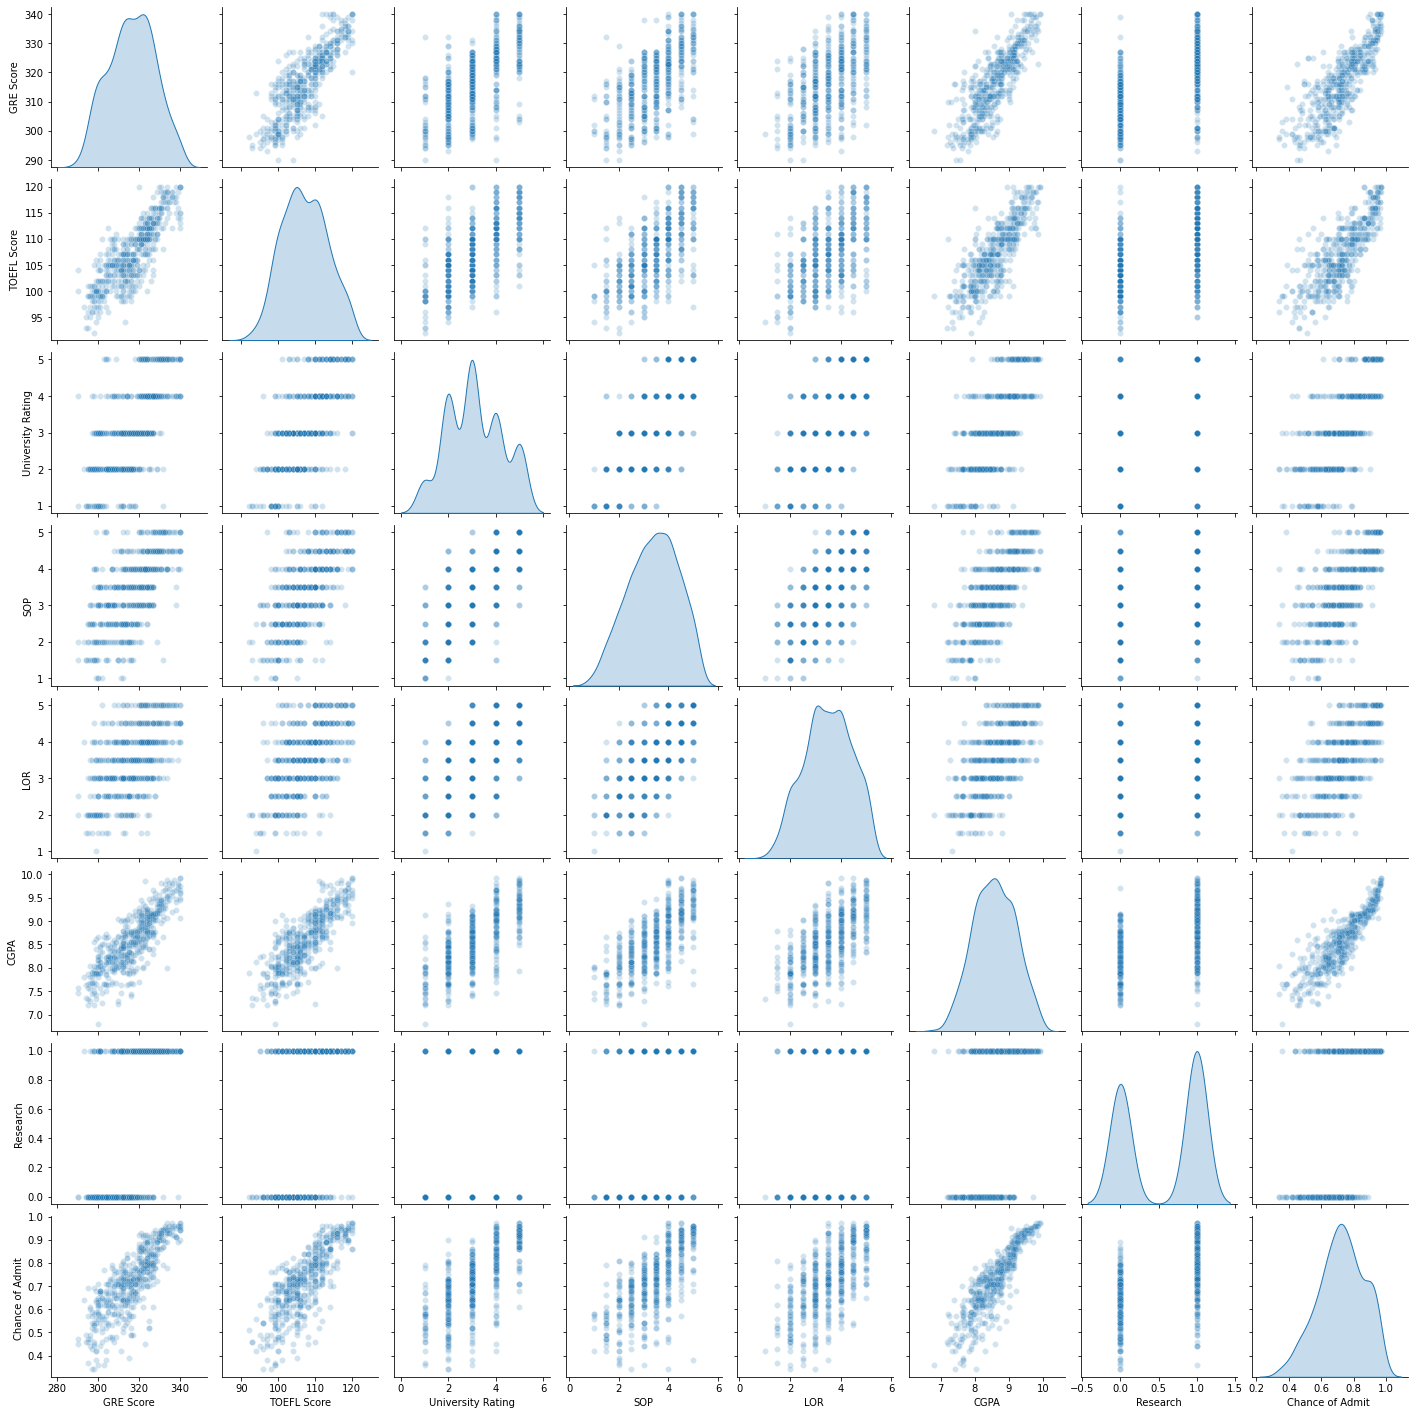

In [12]:
sns.pairplot(dataset,diag_kind='kde',plot_kws={'alpha': .2});

Chance of Admit                                                    \
                    count      mean       std   min     25%    50%     75%   
Research                                                                     
0                   220.0  0.634909  0.111918  0.34  0.5675  0.645  0.7100   
1                   280.0  0.789964  0.123208  0.36  0.7200  0.800  0.8925   

                
           max  
Research        
0         0.89  
1         0.97

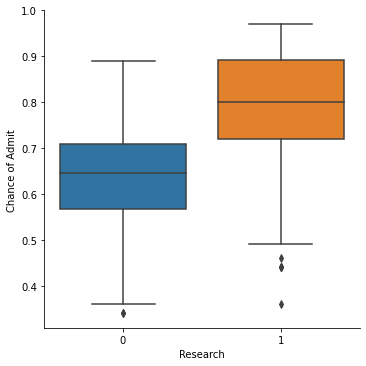

In [13]:
sns.factorplot(y="Chance of Admit ",x='Research',data=dataset,kind='box');
dataset.loc[:,['Research','Chance of Admit ']].groupby('Research').describe()

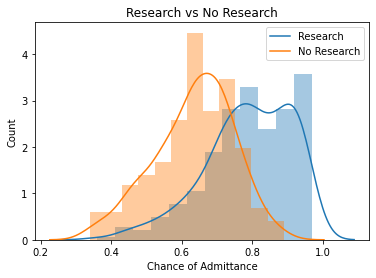

In [14]:
sns.distplot(dataset[dataset.loc[:,'Research'] == 1].loc[:,['Chance of Admit ']],kde=True);
sns.distplot(dataset[dataset.loc[:,'Research'] == 0].loc[:,['Chance of Admit ']],kde=True);
plt.xlabel('Chance of Admittance')
plt.ylabel('Count')
plt.title('Research vs No Research');
plt.legend(['Research','No Research']);

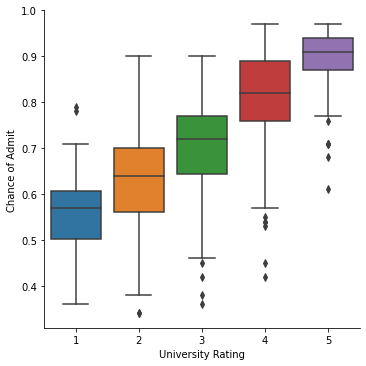

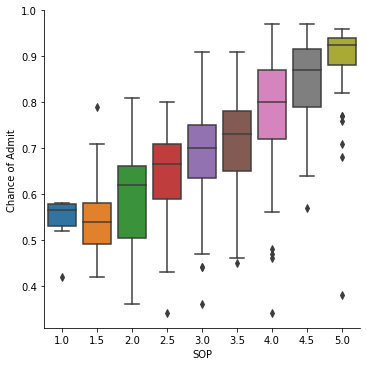

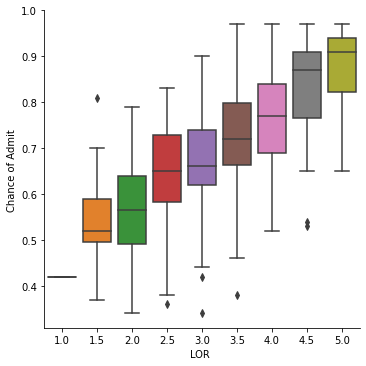

In [15]:
sns.factorplot(x='University Rating',y='Chance of Admit ',kind='box',data=dataset);
sns.factorplot(x='SOP',y='Chance of Admit ',kind='box',data=dataset);
sns.factorplot(x='LOR ',y='Chance of Admit ',kind='box',data=dataset);

In [16]:
target = dataset.pop('Chance of Admit ')

## Split into train/test datasets

In [20]:
X_train,X_test,y_train,y_test = train_test_split(dataset.values.astype(np.float32),
                                                 target.values.reshape(-1,1).astype(np.float32),
                                                 test_size=.2,
                                                 random_state=42)

## Standard Normalization Preprocess¶

In [23]:
# normalize data to 0 mean and unit std
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Set Up Neural Network

In [26]:
from skorch import NeuralNetRegressor

from sklearn.model_selection import RandomizedSearchCV

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [27]:
class MyModule(nn.Module):
    def __init__(self,num_units=10,nonlin=F.relu,drop=.5):
        super(MyModule,self).__init__()
        
        self.module = nn.Sequential(
            nn.Linear(7,num_units),
            nn.LeakyReLU(),
            nn.Dropout(p=drop),
            nn.Linear(num_units,1),
        )
        
    def forward(self,X):
        X = self.module(X)
        return X

## Wrap Pytorch Neural Network in Scorch Wrapper

In [29]:
net = NeuralNetRegressor(
    MyModule,
    criterion=nn.MSELoss,
    max_epochs=10,
    optimizer=optim.Adam,
    optimizer__lr = .005
)

## Randomized Hyperparametr Search

In [30]:
lr = (10**np.random.uniform(-5,-2.5,1000)).tolist()
params = {
    'optimizer__lr': lr,
    'max_epochs':[300,400,500],
    'module__num_units': [14,20,28,36,42],
    'module__drop' : [0,.1,.2,.3,.4]
}

gs = RandomizedSearchCV(net,params,refit=True,cv=3,scoring='neg_mean_squared_error',n_iter=100)

In [31]:
%%capture
gs.fit(X_train_scaled,y_train);

In [32]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [33]:
report(gs.cv_results_,10)

Model with rank: 1
Mean validation score: -0.004 (std: 0.000)
Parameters: {'optimizer__lr': 0.0016047416346836212, 'module__num_units': 20, 'module__drop': 0.3, 'max_epochs': 500}

Model with rank: 2
Mean validation score: -0.004 (std: 0.000)
Parameters: {'optimizer__lr': 0.0019479796861253515, 'module__num_units': 28, 'module__drop': 0.4, 'max_epochs': 500}

Model with rank: 3
Mean validation score: -0.004 (std: 0.000)
Parameters: {'optimizer__lr': 0.0016520062867544682, 'module__num_units': 42, 'module__drop': 0.2, 'max_epochs': 500}

Model with rank: 4
Mean validation score: -0.004 (std: 0.000)
Parameters: {'optimizer__lr': 0.0031255973030533605, 'module__num_units': 28, 'module__drop': 0.1, 'max_epochs': 300}

Model with rank: 5
Mean validation score: -0.004 (std: 0.000)
Parameters: {'optimizer__lr': 0.0018063186685833813, 'module__num_units': 42, 'module__drop': 0.1, 'max_epochs': 400}

Model with rank: 6
Mean validation score: -0.004 (std: 0.000)
Parameters: {'optimizer__lr': 0.0

## Display Learning curves to see if overfitting or underfitting data

In [35]:
# get training and validation loss
epochs = [i for i in range(len(gs.best_estimator_.history))]
train_loss = gs.best_estimator_.history[:,'train_loss']
valid_loss = gs.best_estimator_.history[:,'valid_loss']

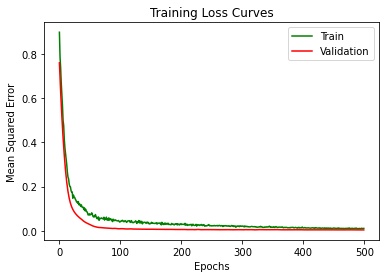

In [36]:
plt.plot(epochs,train_loss,'g-');
plt.plot(epochs,valid_loss,'r-');
plt.title('Training Loss Curves');
plt.xlabel('Epochs');
plt.ylabel('Mean Squared Error');
plt.legend(['Train','Validation']);

## See Regression Metrics to evaluate on test dataset

In [37]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

In [38]:
# predict on test data
y_pred = gs.best_estimator_.predict(X_test_scaled.astype(np.float32))

In [39]:
# get RMSE
MSE(y_test,y_pred)**(1/2)

0.06176495829216838

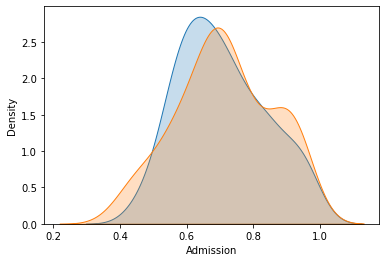

In [40]:
sns.kdeplot(y_pred.squeeze(), label='estimate', shade=True)
sns.kdeplot(y_test.squeeze(), label='true', shade=True)
plt.xlabel('Admission');

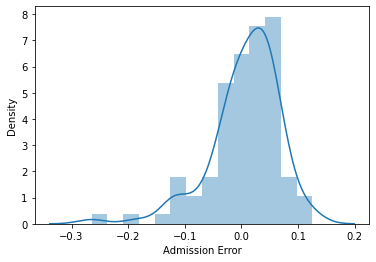

In [41]:
sns.distplot(y_test.squeeze()-y_pred.squeeze(),label='error');
plt.xlabel('Admission Error');

0.8134518323766621


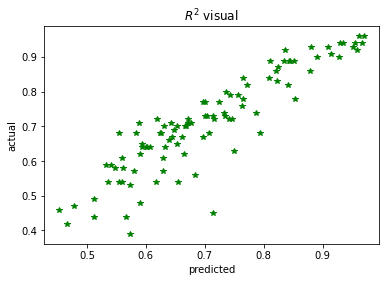

In [42]:
# show R^2 plot
print(r2_score(y_test,y_pred))
plt.plot(y_pred,y_test,'g*')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('$R^{2}$ visual');

In [43]:
# show where the big errors were
errors = np.where(abs(y_test-y_pred)>.2)
for tup in zip(y_test[errors],y_pred[errors]):
    print(tup)

(0.45, 0.71467274)
